# 0.0 IMPORTS

In [1]:
import pandas as pd
import numpy as np
import re
from IPython.display import HTML, display
import warnings
from matplotlib import pyplot as plt
from sklearn import cluster as c
from sklearn import metrics as met
from sklearn import preprocessing as pp
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from plotly import express as px
import seaborn as sns
import umap.umap_ as umap

C:\Users\gusta\anaconda3\envs\insiders\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 0.1 HELPER FUNCTIONS

In [2]:
def jupyter_settings():
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )

jupyter_settings();
warnings.filterwarnings("ignore");

## 0.2 LOADING DATA 

In [3]:
df_raw = pd.read_csv('dataset/Ecommerce.csv',encoding='mbcs')

# 1.0 DATA DESCRIPTION

In [4]:
df1 = df_raw.copy()

## 1.1 DATA DIMENSIONS

In [5]:
print('Rows: {}'.format(df1.shape[0]))
print('Columns: {}'.format(df1.shape[1]))

Rows: 541909
Columns: 9


## 1.2 DATA TYPES

In [6]:
df1.dtypes

InvoiceNo       object
StockCode       object
Description     object
Quantity         int64
InvoiceDate     object
UnitPrice      float64
CustomerID     float64
Country         object
Unnamed: 8     float64
dtype: object

In [7]:
df1.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Unnamed: 8
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.55,17850.0,United Kingdom,NaN
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.39,17850.0,United Kingdom,NaN
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.75,17850.0,United Kingdom,NaN
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.39,17850.0,United Kingdom,NaN
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.39,17850.0,United Kingdom,NaN


In [8]:
df1['InvoiceDate'] = pd.to_datetime(df1['InvoiceDate']).dt.date
df1 = df1.drop('Unnamed: 8',axis=1)

In [9]:
df1.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2016-11-29,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2016-11-29,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2016-11-29,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2016-11-29,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2016-11-29,3.39,17850.0,United Kingdom


## 1.3 CHECKING NA DATA

In [10]:
df1.isna().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

## 1.4 REPLACING NA 

In [11]:
df_missing = df1[df1['CustomerID'].isna()]
df_not_missing = df1[~df1['CustomerID'].isna()]
print(df_missing.shape)
print(df_not_missing.shape)

(135080, 8)
(406829, 8)


In [12]:
df_backup = pd.DataFrame(df_missing['InvoiceNo'].drop_duplicates())
df_backup['CustomerID'] = np.arange(19000,19000+len(df_backup),1)

df1 = pd.merge(df1,df_backup,on='InvoiceNo',how='left')

df1['CustomerID'] = df1['CustomerID_x'].combine_first(df1['CustomerID_y'])
df1 = df1.drop(columns=['CustomerID_x','CustomerID_y'])

In [13]:
df1.isna().sum()

InvoiceNo         0
StockCode         0
Description    1454
Quantity          0
InvoiceDate       0
UnitPrice         0
Country           0
CustomerID        0
dtype: int64

## 1.5 CHANGING TYPE 

In [14]:
df1['CustomerID'] = df1['CustomerID'].astype(int) 

## 1.6 DESCRIPTIVE STATISTICS 

In [15]:
num_attributes = df1.select_dtypes(include=['int64','int32','float64'])
cat_attributes = df1.select_dtypes(exclude=['int64','float64','datetime64[ns]'])

### 1.6.1 NUMERICAL ATTRIBUTES

In [16]:
#central tendency
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T
#dispersion
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(np.min)).T
d3 = pd.DataFrame(num_attributes.apply(np.max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max()-x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T    

#concat
table = pd.concat([d2,d3,d4,ct1,ct2,d1,d5,d6]).T
table.columns = ['min','max','range','mean','median','std','skew','kurtosis']
table

,min,max,range,mean,median,std,skew,kurtosis
Quantity,-80995.00,80995.0,161990.00,9.552250,3.00,218.080957,-0.264076,119769.160031
UnitPrice,-11062.06,38970.0,50032.06,4.611114,2.08,96.759764,186.506972,59005.719097
CustomerID,12346.00,22709.0,10363.00,16688.840453,16249.00,2911.408666,0.487449,-0.804287


### 1.6.2 CATEGORICAL ATTRIBUTES

In [17]:
len(cat_attributes.loc[cat_attributes['InvoiceNo'].apply(lambda x: bool(re.search('[^0-9]+',str(x)))),'InvoiceNo'].drop_duplicates())

3839

In [18]:
cat_attributes.loc[cat_attributes['StockCode'].apply(lambda x: bool(re.search('^[a-zA-Z]+$',str(x)))),'StockCode'].unique()

array(['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY',
       'DCGSSGIRL', 'PADS', 'B', 'CRUK'], dtype=object)

#### Invoice No

In [19]:
df_letter_invoices = df1.loc[df1['InvoiceNo'].apply(lambda x: bool(re.search('[^0-9]+',str(x)))),:]
display(len(df_letter_invoices))
display(len(df_letter_invoices[df_letter_invoices['Quantity']<0]))

9291

9288

#### Stock Code

In [20]:
df1.loc[df1['StockCode'].apply(lambda x: bool(re.search('^[a-zA-Z]+$',str(x)))),'StockCode'].unique()

array(['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY',
       'DCGSSGIRL', 'PADS', 'B', 'CRUK'], dtype=object)

#### Country

In [21]:
df1['Country'].unique()

array(['United Kingdom', 'France', 'Australia', 'Netherlands', 'Germany',
       'Norway', 'EIRE', 'Switzerland', 'Spain', 'Poland', 'Portugal',
       'Italy', 'Belgium', 'Lithuania', 'Japan', 'Iceland',
       'Channel Islands', 'Denmark', 'Cyprus', 'Sweden', 'Austria',
       'Israel', 'Finland', 'Bahrain', 'Greece', 'Hong Kong', 'Singapore',
       'Lebanon', 'United Arab Emirates', 'Saudi Arabia',
       'Czech Republic', 'Canada', 'Unspecified', 'Brazil', 'USA',
       'European Community', 'Malta', 'RSA'], dtype=object)

# 2.0 VARIABLE FILTERING

In [22]:
df2 = df1.copy()

In [23]:
#unit
df2 = df2[df2['UnitPrice']>=0.04]
#stock code
df2 = df2[~df2['StockCode'].isin(['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY','DCGSSGIRL', 'PADS', 'B', 'CRUK'])]
#description
df2 = df2.drop(columns='Description',axis=1)
#map
df2 = df2[~df2['Country'].isin(['European Community', 'Unspecified'])]
#quantity
df_returns = df2[df2['Quantity']<0]
df_purchase = df2[df2['Quantity']>0]

# 3.0 FEATURE ENGINEERING

In [24]:
df3 = df2.copy()
df3_purchase = df_purchase.copy()
df3_returns = df_returns.copy()

## 3.1 FEATURE CREATION

In [25]:
df3.head()

,InvoiceNo,StockCode,Quantity,InvoiceDate,UnitPrice,Country,CustomerID
0,536365,85123A,6,2016-11-29,2.55,United Kingdom,17850
1,536365,71053,6,2016-11-29,3.39,United Kingdom,17850
2,536365,84406B,8,2016-11-29,2.75,United Kingdom,17850
3,536365,84029G,6,2016-11-29,3.39,United Kingdom,17850
4,536365,84029E,6,2016-11-29,3.39,United Kingdom,17850


### 3.1.1 GROSS REVENUE

In [26]:
df3['GrossRevenue'] = df3['Quantity'] * df3['UnitPrice']
df_m = df3[['CustomerID','GrossRevenue']].groupby('CustomerID').sum().reset_index()
df_m.head()

,CustomerID,GrossRevenue
0,12346,0.00
1,12347,4310.00
2,12348,1437.24
3,12349,1457.55
4,12350,294.40


### 3.1.2 RECENCY: DAYS FROM LAST PURCHASE

In [27]:
df_r = df3_purchase[['CustomerID','InvoiceDate']].groupby('CustomerID').max().reset_index()
df_r['RecencyDays'] = (df3_purchase['InvoiceDate'].max()-df_r['InvoiceDate']).dt.days
df_r.drop('InvoiceDate',axis=1,inplace=True)
df_r.head()

,CustomerID,RecencyDays
0,12346,325
1,12347,2
2,12348,75
3,12349,18
4,12350,310


### 3.1.3 QUANTITY OF INVOICES

In [28]:
df_q = df3_purchase[['CustomerID','InvoiceNo']].drop_duplicates().groupby('CustomerID').count().reset_index()
df_q.head()

,CustomerID,InvoiceNo
0,12346,1
1,12347,7
2,12348,4
3,12349,1
4,12350,1


### 3.1.3 QUANTITY OF PRODUCTS

In [29]:
df_qp = df3[['CustomerID','Quantity']].drop_duplicates().groupby('CustomerID').sum().reset_index()
df_qp.head()

,CustomerID,Quantity
0,12346,0
1,12347,477
2,12348,604
3,12349,147
4,12350,52


### 3.1.4 AVERAGE TICKET

In [30]:
df_at=df3[['CustomerID','GrossRevenue']].groupby('CustomerID').mean().reset_index().rename(columns={'GrossRevenue':'AvgTicket'})
df_at.head()

,CustomerID,AvgTicket
0,12346,0.000000
1,12347,23.681319
2,12348,53.231111
3,12349,20.243750
4,12350,18.400000


### 3.1.5 NUMBER OF RETURNS

In [31]:
df3_returns = df3_returns[['CustomerID','InvoiceNo']].drop_duplicates().groupby('CustomerID').count().reset_index().rename(columns={'InvoiceNo':'Returns'})
df3_returns.head()

,CustomerID,Returns
0,12346,1
1,12352,1
2,12359,2
3,12362,3
4,12375,1


### 3.1.5 AVERAGE RECENCY DAYS

In [32]:
df_aux = df3[['CustomerID','InvoiceDate']].drop_duplicates().sort_values(['CustomerID','InvoiceDate'])
df_aux['NextCustomerID'] = df_aux['CustomerID'].shift()
df_aux['LastDate'] = df_aux['InvoiceDate'].shift()

df_aux['AvgRecencyDays'] = df_aux.apply(lambda x: (x['InvoiceDate'] - x['LastDate']).days if x['CustomerID'] == x['NextCustomerID'] else np.nan, axis=1)

df_aux = df_aux.drop(['InvoiceDate','NextCustomerID','LastDate'],axis=1).dropna()
df_rd = df_aux.groupby('CustomerID').mean().reset_index()
df_rd.head()

,CustomerID,AvgRecencyDays
0,12347,60.833333
1,12348,94.333333
2,12352,43.333333
3,12356,151.500000
4,12358,149.000000


### 3.1.5 FREQUENCY PURCHASE

In [55]:
df_aux = (df3_purchase[['CustomerID','InvoiceNo','InvoiceDate']].drop_duplicates()
                                                                .groupby('CustomerID')
                                                                .agg(max_=('InvoiceDate','max'),
                                                                     min_=('InvoiceDate','min'),
                                                                     days_=('InvoiceDate',lambda x: ((x.max()-x.min()).days) + 1),
                                                                     buy_=('InvoiceNo','count'))).reset_index()

df_aux['Frequency'] = df_aux[['buy_','days_']].apply(lambda x: x['buy_']/x['days_'] if x['days_'] != 0 else 0, axis=1)
df_f = df_aux[['CustomerID','Frequency']]

### 3.1.6 MERGING NEW FEATURES

In [67]:
df_ref = pd.merge(df_m,df_r,on='CustomerID',how='left')
df_ref = pd.merge(df_ref,df_q,on='CustomerID',how='left')
df_ref = pd.merge(df_ref,df_qp,on='CustomerID',how='left')
df_ref = pd.merge(df_ref,df_at,on='CustomerID',how='left')
df_ref = pd.merge(df_ref,df3_returns,on='CustomerID',how='left')
df_ref = pd.merge(df_ref,df_rd,on='CustomerID',how='left')
df_ref = pd.merge(df_ref,df_f,on='CustomerID',how='left')
df_ref['Returns'] = df_ref['Returns'].fillna(value=0)
df_ref['Frequency'] = df_ref['Frequency'].fillna(value=0)
df_ref.head()

,CustomerID,GrossRevenue,RecencyDays,InvoiceNo,Quantity,AvgTicket,Returns,AvgRecencyDays,Frequency
0,12346,0.00,325.0,1.0,0,0.000000,1.0,NaN,1.000000
1,12347,4310.00,2.0,7.0,477,23.681319,0.0,60.833333,0.019126
2,12348,1437.24,75.0,4.0,604,53.231111,0.0,94.333333,0.014085
3,12349,1457.55,18.0,1.0,147,20.243750,0.0,NaN,1.000000
4,12350,294.40,310.0,1.0,52,18.400000,0.0,NaN,1.000000


In [69]:
df_ref.isna().sum()

CustomerID           0
GrossRevenue         0
RecencyDays         91
InvoiceNo           91
Quantity             0
AvgTicket            0
Returns              0
AvgRecencyDays    2816
Frequency            0
dtype: int64

# 4.0 EXPLORATORY DATA ANALYSIS

In [36]:
df4 = df_ref.dropna().copy()
df4.isna().sum()

CustomerID        0
GrossRevenue      0
RecencyDays       0
InvoiceNo         0
Quantity          0
AvgTicket         0
Returns           0
AvgRecencyDays    0
dtype: int64

# 5.0 DATA PREPARATION

In [37]:
df5 = df4.copy()

In [38]:
ss = pp.StandardScaler()
df5['GrossRevenue'] = ss.fit_transform(df5[['GrossRevenue']])
df5['RecencyDays'] = ss.fit_transform(df5[['RecencyDays']])
df5['InvoiceNo'] = ss.fit_transform(df5[['InvoiceNo']])
df5['AvgTicket'] = ss.fit_transform(df5[['AvgTicket']])
df5['Returns'] = ss.fit_transform(df5[['Returns']])
df5.head()

,CustomerID,GrossRevenue,RecencyDays,InvoiceNo,Quantity,AvgTicket,Returns,AvgRecencyDays
1,12347,0.170573,-0.801192,0.144196,477,-0.072428,-0.488948,60.833333
2,12348,-0.118846,0.137791,-0.194594,604,0.376760,-0.488948,94.333333
5,12352,-0.136157,-0.363858,0.144196,45,-0.203414,-0.053529,43.333333
9,12356,-0.013044,-0.543937,-0.307524,546,0.219515,-0.488948,151.500000
11,12358,-0.170144,-0.814055,-0.420454,84,0.397444,-0.488948,149.000000


# 6.0 FEATURE SELECTION

In [39]:
df6 = df5.copy()

# 7.0 HYPERPARAMETER FINE TUNING

In [40]:
X = df6.drop(columns=['CustomerID'])
clusters = [2,3,4,5,6,7]
X.head()

,GrossRevenue,RecencyDays,InvoiceNo,Quantity,AvgTicket,Returns,AvgRecencyDays
1,0.170573,-0.801192,0.144196,477,-0.072428,-0.488948,60.833333
2,-0.118846,0.137791,-0.194594,604,0.376760,-0.488948,94.333333
5,-0.136157,-0.363858,0.144196,45,-0.203414,-0.053529,43.333333
9,-0.013044,-0.543937,-0.307524,546,0.219515,-0.488948,151.500000
11,-0.170144,-0.814055,-0.420454,84,0.397444,-0.488948,149.000000


## 7.1 WITHIN-CLUSTER SUM OF SQUARES (WSS)

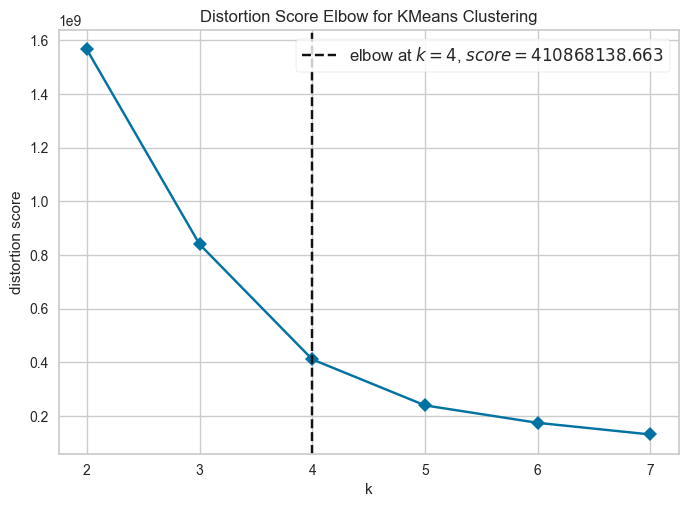

In [41]:
kmeans = KElbowVisualizer(c.KMeans(),k=clusters,timings=False)
kmeans.fit(X)
kmeans.show();

## 7.2 SILHOUETTE SCORE

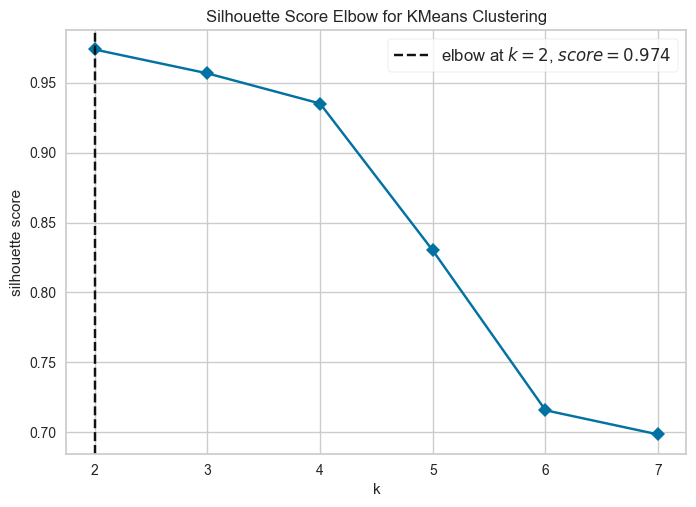

In [42]:
kmeans = KElbowVisualizer(c.KMeans(),k=clusters, metric='silhouette',timings=False)
kmeans.fit(X)
kmeans.show();

## 7.3 SILHOUETTE ANALYSIS

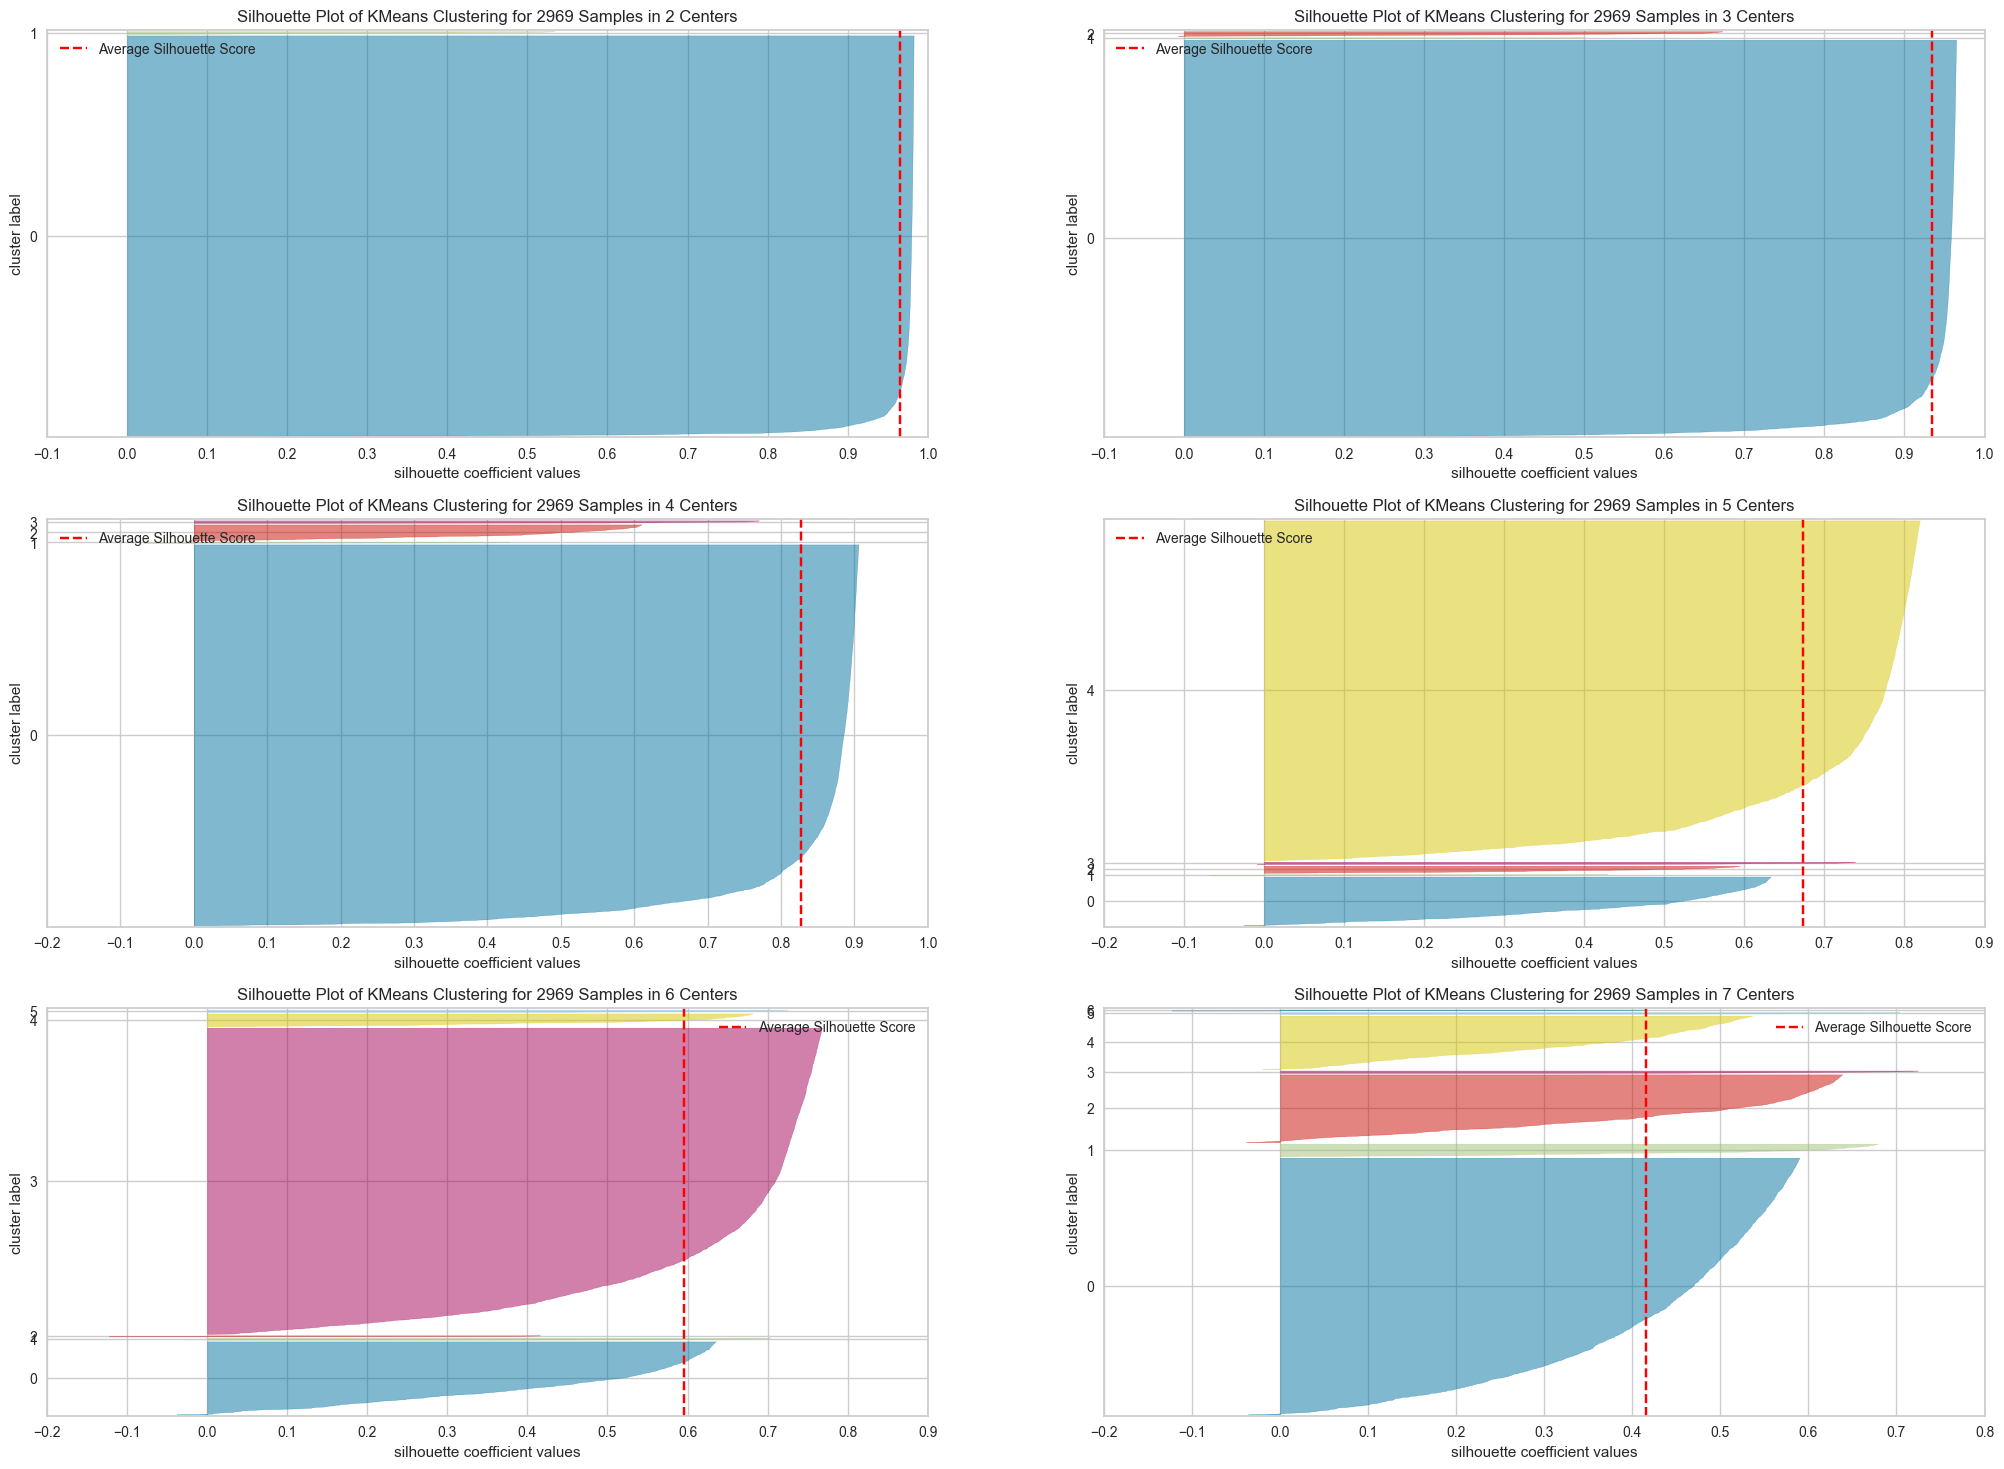

In [43]:
fig,ax = plt.subplots(3,2,figsize=(25,18))

for k in clusters:
    km = c.KMeans(n_clusters=k,init='random',n_init=10,max_iter=100,random_state=42)
    q, mod = divmod(k,2)    
    visualizer = SilhouetteVisualizer(km,colors='yellowbrick',ax=ax[q-1][mod])
    visualizer.fit(X)
    visualizer.finalize()

# 8.0 MODEL TRAINING

In [44]:
k = 4
kmeans = c.KMeans(init='random',n_clusters=k,max_iter=300,random_state=42)
preds = kmeans.fit_predict(X)
labels = kmeans.labels_

In [45]:
print('WSS value:{}'.format(kmeans.inertia_))
print('SS value:{}'.format(met.silhouette_score(X,preds)))

WSS value:687177720.4800076
SS value:0.8267711931428593


# 9.0 CLUSTER ANALYSIS

In [46]:
df9 = df4.copy()
df9['cluster'] = labels
df9.head()

,CustomerID,GrossRevenue,RecencyDays,InvoiceNo,Quantity,AvgTicket,Returns,AvgRecencyDays,cluster
1,12347,4310.00,2.0,7.0,477,23.681319,0.0,60.833333,0
2,12348,1437.24,75.0,4.0,604,53.231111,0.0,94.333333,0
5,12352,1265.41,36.0,7.0,45,15.064405,1.0,43.333333,0
9,12356,2487.43,22.0,3.0,546,42.886724,0.0,151.500000,0
11,12358,928.06,1.0,2.0,84,54.591765,0.0,149.000000,0


## 9.1 VISUALIZATION INSPECTION

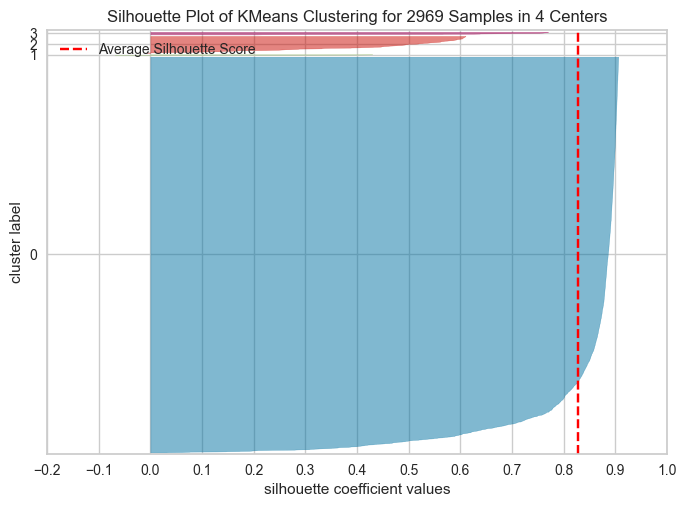

In [47]:
visualizer = SilhouetteVisualizer(kmeans,colors='yellowbrick')
visualizer.fit(X)
visualizer.finalize()

## 9.2 2D PLOT

In [48]:
df_viz = df9.drop(columns=['CustomerID'])
#sns.pairplot(df_viz,hue='cluster');

## 9.3 UMAP

<AxesSubplot: xlabel='embedding_x', ylabel='embedding_y'>

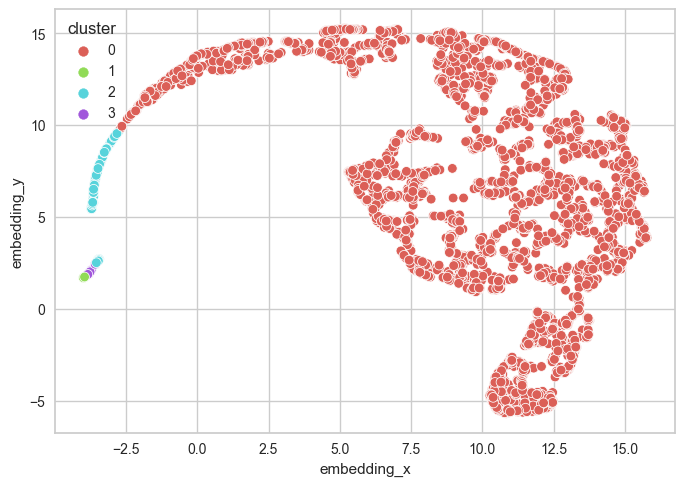

In [49]:
reducer = umap.UMAP(n_neighbors=20, random_state=42)
embedding = reducer.fit_transform(X)
df_viz['embedding_x'] = embedding[:,0]
df_viz['embedding_y'] = embedding[:,1]

sns.scatterplot(x='embedding_x',y='embedding_y',hue='cluster',palette=sns.color_palette('hls',n_colors=len(df_viz['cluster'].unique())), data=df_viz)

## 9.4 CLUSTER PROFILE

In [50]:
#Qty per cluster
df_cluster = df9[['CustomerID','cluster']].groupby('cluster').count().reset_index()
df_cluster['perc_customer'] = 100*(df_cluster['CustomerID']/df_cluster['CustomerID'].sum())

#Avg gross rev
df_avg_grossrev = df9[['GrossRevenue','cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster,df_avg_grossrev,how='inner',on='cluster')

#Avg recency days
df_avg_rec = df9[['RecencyDays','cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster,df_avg_rec,how='inner',on='cluster')

#Avg invoice num
df_avg_invnum = df9[['InvoiceNo','cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster,df_avg_invnum,how='inner',on='cluster')

#Avg ticket
df_avg_ticket = df9[['AvgTicket','cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster,df_avg_ticket,how='inner',on='cluster')

df_cluster.drop(columns=['CustomerID'])

,cluster,perc_customer,GrossRevenue,RecencyDays,InvoiceNo,AvgTicket
0,0,95.015157,1665.696803,65.851826,4.926622,22.620343
1,1,0.269451,115099.805000,6.125000,42.125000,395.063230
2,2,4.041765,11186.651750,38.441667,18.650000,104.835142
3,3,0.673627,40372.450500,22.000000,25.950000,245.171377
